# Análisis de datos aplicado al fútbol

__Autor:__ Aarón Puche Benedito

## Índice

1. Objetivos del proyecto
2. Dataset FBREF
        2.1 Robert Lewandowski vs Memphis Depay
        2.2 Jugadores similares a Sergio Busquets
3. Dataset StatsBomb: análisis partido FCB 3 - 1 MUN

## 1. Objetivos del proyecto 

Durante los últimos años el uso del *big data* en el mundo del fútbol ha ido en ascenso, siendo utilizado tanto por jugadores como [Kevin De Bruyne](https://www.mundodeportivo.com/futbol/premier-league/20210408/493119371863/kevin-de-bruyne-renovacion-por-big-data.html) a la hora de renovar sus contratos o por equipos como el [Liverpool](https://www.nytimes.com/2019/05/22/magazine/soccer-data-liverpool.html) y el [Brentford](https://towardsdatascience.com/brentford-fc-the-moneyball-story-in-football-9726619d0d1a) para confeccionar sus plantillas. Por este motivo vamos a realizar un pequeño trabajo sobre algunas de las posibilidades que nos ofrece el *big data* aplicado al fútbol.

Este trabajo se divide en dos partes. Por un lado, analizaremos las características de los jugadores. En concreto, veremos una comparación entre el nuevo fichaje del FC Barcelona, Robert Lewandowski, con uno de los jugadores que más han ocupado la posición de delantero centro en el FC Barcelona la temporada anterior, Memphis Depay. Luego buscaremos que jugadores podrían ser los sustitutos de Sergio Busquets basándonos en los jugadores con las características más similares. 

En la siguiente sección analizaremos una de las finales de la Champions League, la correspondiente a la temporada 2010/2011 que enfrentó al Manchester United de Sir Alex Ferguson y al FC Barcelona de Pep Guardiola. Analizaremos las distintas fases del partido mediante mapas de pases.

## 2.Dataset FBREF

Obtendremos los datos a partir de la web [fbref.com](fbref.com). Esta web nos permite seleccionar fácilmente aquellas características que más nos interesan.

### 2.1 Lewandowski vs Memphis

Estos jugadores que vamos a comparar son delanteros, por lo tanto, tendremos que elegir los atributos adecuados. Nos basaremos en el modelo de Radar Chart de [StatsBomb](https://statsbomb.com/articles/soccer/understanding-statsbomb-radars/) con algunas modificaciones. Escogemos los siguientes atributos:
- Gls/90: Goles por cada 90 minutos
- Ast/90: Asistencias cada 90 minutos
- xG/90: Goles esperados cada 90 minutos
- xA/90: Asistencias esperadas cada 90 minutos
- Sh/90: Disparos cada 90 minutos
- SoT/90: Disparos a portería cada 90 minutos
- Dribbles_att: Regates intentados
- Dribbles_succ%: Porcentaje de regates completados
- Press: Presiones intentadas
- Press_succ%: Porcentaje de presiones que consiguen recuperar el balón
- Aerial_won: Duelos aéreos ganados

**Cargamos el dataset** que hemos descargado de FBREF con los atributos elegidos y algunos más, relacionados con la posición de mediocampista, que nos serán necesarios en el siguiente punto.

In [2]:
# Importamos las librerías necesarias
import pandas as pd
import matplotlib as plt
from soccerplots.radar_chart import Radar
import numpy as np

In [2]:
df_players = pd.read_csv('data/fbref/players.csv')
df_players.head()

Rk             Player   Nation Position          Squad                Comp  \
0   1         Max Aarons  eng ENG       DF   Norwich City  eng Premier League   
1   2   Yunis Abdelhamid   ma MAR       DF          Reims          fr Ligue 1   
2   3  Salis Abdul Samed   gh GHA       MF  Clermont Foot          fr Ligue 1   
3   4    Laurent Abergel   fr FRA       MF        Lorient          fr Ligue 1   
4   5        Charles Abi   fr FRA       FW  Saint-Étienne          fr Ligue 1   

    Age  Matches  Gls  Ast  ...  Carries_1/3  Tkl  TklW  Press  Press_succ  \
0  21.0       34    0    2  ...           53   69    37    434         113   
1  33.0       34    2    0  ...           24   62    46    451         162   
2  21.0       31    1    0  ...           20   55    34    641         179   
3  28.0       34    0    2  ...           37  117    73    918         259   
4  21.0        1    0    0  ...            1    0     0     14           1   

   Press_succ%  Int  Aerial_won  Aerial_lost  Aerial_won%  
0         26.0   56          15           51         22.7  
1         35.9  103          67           45         59.8  
2         27.9   51          24           24         50.0  
3         28.2   84          14           14         50.0  
4          7.1    0           1            0        100.0  

[5 rows x 39 columns]

Comprobamos que estén todas las columnas que queremos:

In [3]:
df_players.columns

Index(['Rk', 'Player', 'Nation', 'Position', 'Squad', 'Comp', 'Age', 'Matches',
       'Gls', 'Ast', 'Gls/90', 'Ast/90', 'xG', 'xA', 'xG/90', 'xA/90', 'Sh',
       'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'Passes_cmp', 'Passes_att',
       'Passes_cmp%', 'Passes_1/3', 'Touches_area', 'Dribbles_succ',
       'Dribbles_att', 'Dribbles_succ%', 'Carries_1/3', 'Tkl', 'TklW', 'Press',
       'Press_succ', 'Press_succ%', 'Int', 'Aerial_won', 'Aerial_lost',
       'Aerial_won%'],
      dtype='object')

Una vez tenemos los datos de los jugadores, utilizaremos la librería *[soccerplots](https://github.com/Slothfulwave612/soccerplots/blob/master/docs/radar_chart.md)* para dibujar los *radar charts*.

Para poder dibujarlos necesitaremos tener los pares de jugadores a comparar.

Empezamos **capturando los datos de los jugadores** y eligiendo solo los parámetros que vamos a visualizar:

In [4]:
df_lewa_depay = df_players[(df_players['Player'] == 'Robert Lewandowski') |
                          (df_players['Player'] == 'Memphis Depay')].reset_index()

df_lewa_depay = df_lewa_depay[['Player', 'Gls/90', 'Ast/90', 'xG/90', 'xA/90', 'Sh/90', 'SoT/90', 'Dribbles_att', 
                               'Dribbles_succ%', 'Press', 'Press_succ%', 'Aerial_won']]

df_lewa_depay.head()

Player  Gls/90  Ast/90  xG/90  xA/90  Sh/90  SoT/90  \
0       Memphis Depay    0.58    0.10   0.53   0.19   2.72    1.41   
1  Robert Lewandowski    1.07    0.09   1.00   0.17   4.80    2.35   

   Dribbles_att  Dribbles_succ%  Press  Press_succ%  Aerial_won  
0            66            51.5    210         29.5          18  
1            65            52.3    320         32.8          70

**Creamos una función** siguiendo el ejemplo que nos proporciona la documentación de *soccerplots*.

In [5]:
def plt_radar_chart(players_att, player_name_1, player_name_2):
   
    # Obtenemos los parámetros que vamos a visualizar
    params = list(players_att.columns)
    params = params[1:]
    
    # Configuramos los rangos de sus valores
    ranges = []
    a_values = []
    b_values = []

    for x in params:
        a = min(players_att[params][x])
        a = a - (a*.1)

        b = max(players_att[params][x])
        b = b + (b*.1)

        ranges.append((a,b))

    for x in range(len(players_att['Player'])):
        if players_att['Player'][x] == player_name_1:
            a_values = players_att.iloc[x].values.tolist()
        if players_att['Player'][x] == player_name_2:
            b_values = players_att.iloc[x].values.tolist()

    a_values = a_values[1:]
    b_values = b_values[1:]

    values = [a_values, b_values]
    
    # Definimos un título
    title = dict(
        title_name = player_name_1,
        title_color = 'red',
        title_name_2 = player_name_2,
        title_color_2 = 'blue',
        title_fontsize = 18,
    )
    
    # Visualizamos el gráfico
    radar = Radar(range_fontsize=10)

    fig, ax = radar.plot_radar(ranges=ranges, params=params, values=values, dpi=1000,
                               radar_color=['red', 'blue'],
                               alphas=[.6,.4], title=title, compare=True)
    
    fig.set_size_inches(14, 14)


**Visualizamos la comparación.**

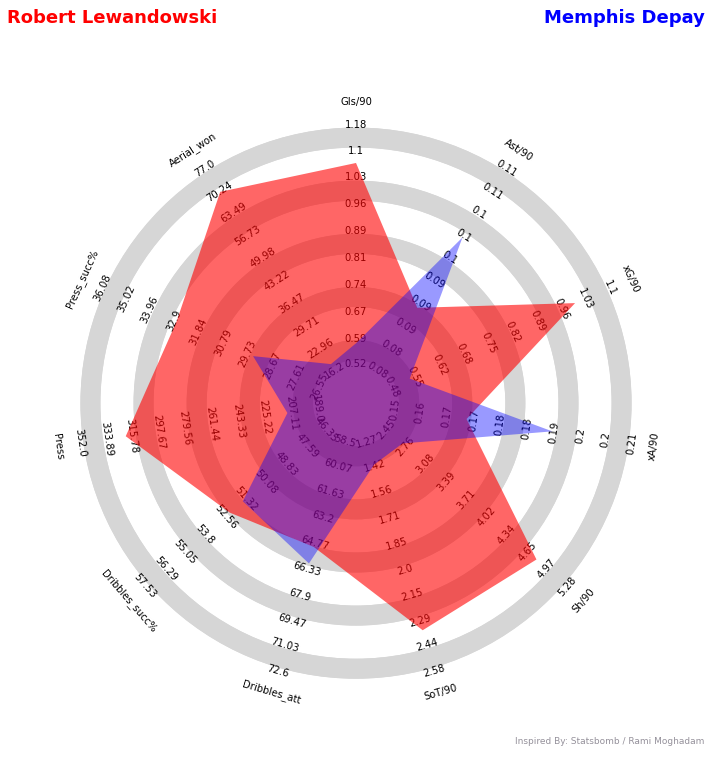

In [8]:
plt_radar_chart(df_lewa_depay, 'Robert Lewandowski', 'Memphis Depay')

Viendo este gráfico podemos ver rápidamente las diferencias entre los dos jugadores. Lewandowski destaca por encima de Memphis en casi todos los atributos, a excepción de regates y asistencias. Tanto uno como otro jugador intentan un número similar de regates y también tienen un acierto similar.

Por lo que respecta a lo que puede aportar este nuevo fichaje al FC Barcelona, vemos que proporciona una mayor amenaza en ataque. Lewandowski dispara más a portería rival y tiene unos goles esperados de un gol cada 90 minutos. Una gran mejora respecto a Memphis Depay. Otro aspecto importante a destacar es el número de presiones que realiza y el éxito que tiene en recuperar el balón. Lewandowski aportará una mayor presión que permitirá al FC Barcelona robar antes la pelota al rival.

### 2.2 Jugadores similares a Sergio Busquets

Sergio Busquets debutó en el FC Barcelona en la temporada 2008-2009 y desde entonces ha sido un jugador clave en el equipo y en la selección española. Actualmente, el jugador tiene 34 años y tarde o temprano el FC Barcelona buscará un sustituto para él.

En este punto vamos a ponernos en el papel de secretario técnico y buscaremos a 5 posibles candidatos para sustituir a Sergio Busquets. Para ello nos basaremos en los datos de FBREF y buscaremos a los jugadores más similares mediante la distancia euclidiana. A grandes rasgos, esta medida nos proporciona la información de como de parecidos son dos conjuntos de valores.

Ahora bien, ¿qué atributos comparamos? Para elegir los atributos nos basaremos en el ejemplo de [radar chart de StatsBomb](https://statsbomb.com/articles/soccer/understanding-statsbomb-radars/) respecto a los mediocampistas. A partir de este ejemplo hemos decidido comparar los jugadores mediante los siguientes atributos:
- Passes_cmp: Pases completados
- Passes_1/3: Pases que llegan al último tercio del campo rival
- Carries_1/3: Progresiones que llegan al último tercio del campo rival
- xA: Asistencias esperadas
- Dribbles_succ: Regates completados
- Press: Presiones intentadas
- Press_succ: Presiones que consiguen recuperar el balón
- TklW: Tackles ganados
- Int: Intercepciones completadas
- xG: Goles esperados
- Sh: Tiros realizados
- SoT: Tiros a portería realizados
- Touches_area: Toques de balón dentro del área rival

**Cargamos el dataset.**

In [3]:
df = pd.read_csv('data/fbref/players.csv')
df.head()

Rk             Player   Nation Position          Squad                Comp  \
0   1         Max Aarons  eng ENG       DF   Norwich City  eng Premier League   
1   2   Yunis Abdelhamid   ma MAR       DF          Reims          fr Ligue 1   
2   3  Salis Abdul Samed   gh GHA       MF  Clermont Foot          fr Ligue 1   
3   4    Laurent Abergel   fr FRA       MF        Lorient          fr Ligue 1   
4   5        Charles Abi   fr FRA       FW  Saint-Étienne          fr Ligue 1   

    Age  Matches  Gls  Ast  ...  Carries_1/3  Tkl  TklW  Press  Press_succ  \
0  21.0       34    0    2  ...           53   69    37    434         113   
1  33.0       34    2    0  ...           24   62    46    451         162   
2  21.0       31    1    0  ...           20   55    34    641         179   
3  28.0       34    0    2  ...           37  117    73    918         259   
4  21.0        1    0    0  ...            1    0     0     14           1   

   Press_succ%  Int  Aerial_won  Aerial_lost  Aerial_won%  
0         26.0   56          15           51         22.7  
1         35.9  103          67           45         59.8  
2         27.9   51          24           24         50.0  
3         28.2   84          14           14         50.0  
4          7.1    0           1            0        100.0  

[5 rows x 39 columns]

**Escogemos los atributos.**

In [4]:
df_players = df[['Player','Passes_cmp','Passes_1/3','Carries_1/3','xA','Dribbles_succ','Press','Press_succ','TklW','Int',
                         'xG','Sh','SoT','Touches_area']]
df_players.head()

Player  Passes_cmp  Passes_1/3  Carries_1/3   xA  Dribbles_succ  \
0         Max Aarons        1087          50           53  1.4             33   
1   Yunis Abdelhamid        1281          81           24  0.8             16   
2  Salis Abdul Samed        1532          77           20  1.1             27   
3    Laurent Abergel        1334         127           37  2.9             42   
4        Charles Abi           2           0            1  0.0              0   

   Press  Press_succ  TklW  Int   xG  Sh  SoT  Touches_area  
0    434         113    37   56  0.7  13    2            29  
1    451         162    46  103  1.2  18    6            28  
2    641         179    34   51  0.8  18    5            17  
3    918         259    73   84  2.0  30    7            15  
4     14           1     0    0  0.0   0    0             3

Ahora **crearemos un par de funciones**. Una función que calculará la [distancia euclidiana](https://en.wikipedia.org/wiki/Euclidean_distance#:~:text=In%20mathematics%2C%20the%20Euclidean%20distance,being%20called%20the%20Pythagorean%20distance.) a partir de la siguiente fórmula:
    
- $dist$ = $\sqrt{\sum_{i=1}^{n} (a_i-b_i)^2}$
    
I otra función donde realizaremos la normalización para que un valor con una magnitud muy elevada no influya de manera mayoritaria sobre el resultado. Utilizaremos una normalización simple como la normalización por la media.

In [5]:
def euclidean_dist(ply1, ply2_df):
    ply1 = ply1.values[1:14]
    ply2_df = ply2_df.iloc[0].values[1:14]
    return np.sqrt(np.sum(np.square(np.array(ply1)-np.array(ply2_df))))

def mean_norm(df):
    return df.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

**Normalizamos** el dataset anterior con los atributos escogidos.

In [6]:
df_players_norm = df_players.copy()
df_players_norm.iloc[:, 1:14] = mean_norm(df_players_norm.iloc[:, 1:14])
df_players_norm.head()

Player  Passes_cmp  Passes_1/3  Carries_1/3        xA  \
0         Max Aarons    1.260963    0.383713     2.068804  0.157786   
1   Yunis Abdelhamid    1.667269    1.140846     0.480637 -0.212806   
2  Salis Abdul Samed    2.192953    1.043152     0.261579 -0.027510   
3    Laurent Abergel    1.778270    2.264334     1.192574  1.084265   
4        Charles Abi   -1.011416   -0.837470    -0.778944 -0.706928   

   Dribbles_succ     Press  Press_succ      TklW       Int        xG  \
0       1.665532  1.457703    1.124627  1.682592  1.747191 -0.356125   
1       0.407235  1.557822    2.086892  2.327660  3.971225 -0.179914   
2       1.221428  2.676806    2.420740  1.467569  1.510591 -0.320883   
3       2.331690  4.308166    3.991785  4.262866  3.072148  0.102022   
4      -0.777044 -1.015840   -1.074836 -0.969357 -0.902723 -0.602819   

         Sh       SoT  Touches_area  
0 -0.128793 -0.411912     -0.001964  
1  0.126677  0.119769     -0.027354  
2  0.126677 -0.013151     -0.306643  
3  0.739805  0.252690     -0.357423  
4 -0.793016 -0.677752     -0.662102

**Buscamos los valores de Sergio Busquets**, 

In [7]:
busquets = df_players_norm[df_players_norm['Player'] == 'Sergio Busquets']
busquets

Player  Passes_cmp  Passes_1/3  Carries_1/3        xA  \
404  Sergio Busquets    4.140707     5.51268     1.247338  0.466612   

     Dribbles_succ     Press  Press_succ      TklW       Int        xG  \
404        0.55527  2.629691    3.166986  4.191192  1.794511 -0.356125   

           Sh       SoT  Touches_area  
404 -0.077699 -0.146071     -0.078134

**Calculamos la distancia euclidiana** de todos los jugadores respecto a Sergio Busquets y vemos los 10 primeros con la menor distancia.

In [8]:
df_players_norm['Dist_Busquets'] = df_players_norm.apply(lambda x: euclidean_dist(x, busquets), axis=1)
df_players_norm.sort_values(by=['Dist_Busquets']).head(11)

Player  Passes_cmp  Passes_1/3  Carries_1/3        xA  \
404    Sergio Busquets    4.140707    5.512680     1.247338  0.466612   
1336   Boubacar Kamara    3.600363    3.632059     0.699694  0.157786   
976      Johan Gastien    3.487267    4.120532     0.754459  0.590143   
885       Jordan Ferri    3.382549    4.413616     1.575924  0.898969   
383   Marcelo Brozović    3.958498    4.584581     2.287862  0.404847   
596    Bryan Cristante    2.079858    4.633429     1.247338  0.281316   
1553      Maxime Lopez    3.920800    4.609005     2.780741  1.084265   
1189   Pierre Højbjerg    3.638061    4.706700     1.302103  0.837204   
477           Casemiro    2.574127    3.583212     0.535401  0.898969   
2285             Rodri    4.402502    5.073054     1.575924  0.157786   
761    Cheick Doucouré    2.542711    3.729753     2.780741  1.207796   

      Dribbles_succ     Press  Press_succ      TklW       Int        xG  \
404        0.555270  2.629691    3.166986  4.191192  1.794511 -0.356125   
1336       0.259201  1.628495    2.518930  2.972729  2.173070 -0.215156   
976        0.333218  2.458898    2.754587  2.184312  2.646269 -0.285641   
885        1.813567  2.288106    2.440378  2.399334  1.037393 -0.497093   
383        0.407235  2.252770    2.243997  2.399334  1.557911 -0.179914   
596        0.259201  2.523682    2.676034  3.187752  1.321312  0.207749   
1553       0.999375  2.105535    2.185083  2.255986  1.889150 -0.144672   
1189       2.183655  2.841709    2.361825  2.542683  2.409669  0.102022   
477        0.185183  1.522486    2.420740  3.617798  1.889150  0.242991   
2285      -0.110887  1.734504    2.263635  2.327660  0.990073  0.348717   
761        1.147410  1.828734    2.440378  3.832820  2.598949 -0.074188   

            Sh       SoT  Touches_area  Dist_Busquets  
404  -0.077699 -0.146071     -0.078134       0.000000  
1336  0.331053 -0.278992      0.328104       2.780581  
976   0.433241  0.252690     -0.078134       2.837234  
885  -0.128793 -0.411912     -0.382813       2.876728  
383   0.841993  1.050211      0.150375       2.936646  
596   1.199651 -0.013151      0.277325       2.952770  
1553  0.024489  0.119769     -0.052744       2.985692  
1189  0.790899  0.651450      0.124985       3.020783  
477   1.301839  0.518530      0.099595       3.444365  
2285  1.506216  1.183132      0.886682       3.514175  
761   0.790899  0.784371     -0.230474       3.556916

Como podemos observar fácilmente, el jugador más similar a Busquets es el propio Busquets, eso nos hace indicar que los cálculos están correctos.

Respecto a los otros 10 jugadores, podemos ver a algunos como Rodri o Casemiro, ambos grandísimos jugadores en la posición de mediocentro en dos grandes equipos como el Manchester City y el Real Madrid.

Para tener un poco más de información de estos jugadores los podemos buscar en el conjunto de datos inicial.

In [169]:
players = ['Boubacar Kamara','Johan Gastien','Jordan Ferri','Marcelo Brozović','Bryan Cristante','Maxime Lopez',
           'Pierre Højbjerg','Casemiro','Rodri', 'Cheick Doucouré']

In [170]:
df[df['Player'].isin(players)]

Rk            Player  Nation Position            Squad  \
383    384  Marcelo Brozović  hr CRO       MF            Inter   
477    478          Casemiro  br BRA       MF      Real Madrid   
596    597   Bryan Cristante  it ITA       MF             Roma   
761    762   Cheick Doucouré  ml MLI       MF             Lens   
885    886      Jordan Ferri  fr FRA       MF      Montpellier   
976    977     Johan Gastien  fr FRA       MF    Clermont Foot   
1189  1190   Pierre Højbjerg  dk DEN       MF        Tottenham   
1336  1337   Boubacar Kamara  fr FRA       MF        Marseille   
1553  1554      Maxime Lopez  fr FRA       MF         Sassuolo   
2285  2286             Rodri  es ESP       MF  Manchester City   

                    Comp   Age  Matches  Gls  Ast  ...  Carries_1/3  Tkl  \
383           it Serie A  28.0       35    2    1  ...           57   75   
477           es La Liga  29.0       32    1    3  ...           25   90   
596           it Serie A  26.0       34    2    0  ...           38   86   
761           fr Ligue 1  21.0       34    1    4  ...           66   86   
885           fr Ligue 1  29.0       34    0    2  ...           44   67   
976           fr Ligue 1  33.0       32    0    1  ...           29   59   
1189  eng Premier League  25.0       36    2    2  ...           39   84   
1336          fr Ligue 1  21.0       34    1    0  ...           28   81   
1553          it Serie A  23.0       35    2    1  ...           66   67   
2285  eng Premier League  25.0       33    7    2  ...           44   65   

      TklW  Press  Press_succ  Press_succ%  Int  Aerial_won  Aerial_lost  \
383     47    569         170         29.9   52          20           29   
477     64    445         179         40.2   59         112           55   
596     58    615         192         31.2   47          92           61   
761     67    497         180         36.2   74          22           24   
885     47    575         180         31.3   41          17           39   
976     44    604         196         32.5   75          21           30   
1189    49    669         176         26.3   70          35           20   
1336    55    463         184         39.7   65          51           42   
1553    45    544         167         30.7   59           7            9   
2285    46    481         171         35.6   40          91           33   

      Aerial_won%  
383          40.8  
477          67.1  
596          60.1  
761          47.8  
885          30.4  
976          41.2  
1189         63.6  
1336         54.8  
1553         43.8  
2285         73.4  

[10 rows x 39 columns]

Aquí comprobamos que todos estos jugadores ocupan la posición de mediocampista.

Volviendo al objetivo que nos habíamos propuesto al inicio de este punto, tenemos que elaborar una lista de 5 posibles candidatos. Viendo los resultados podríamos elegir a Boubacar Kamara, Cheick Doucouré y Maxime Lopez como opciones de futuro por su juventud y que pertenecen a equipos que seguramente aceptarían su traspaso. Luego tenemos otras opciones que seguramente serian más costosas como Pierre Højbjerg o Rodri. Ambos jugadores ja experimentados en competiciones exigentes como la Premier League o la Champions League.

## 3. Dataset StatsBomb

Una vez hemos trabajado sobre algunas características de los jugadores, vamos a analizar un partido. En concreto veremos la final de la Champions League de la temporada 2010/2011 que disputaron el Manchester United y el FC Barcelona.

Para analizar este partido utilizaremos los datos que nos proporciona [StatsBomb](https://github.com/statsbomb/open-data).

Empezamos **cargando los datos**. Para ello utilizaremos la librería [mplsoccer](https://mplsoccer.readthedocs.io/en/latest/index.html) y la función Sbopen. Con esta función podemos cargar nuestros datos a través de su identificador.

In [20]:
# Importamos las librerías necesarias
from mplsoccer import Sbopen, Pitch, VerticalPitch
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [11]:
parser = Sbopen(dataframe=True)
events, related, freeze, tactics = parser.event(18236)

De los distintos conjuntos de datos que nos devuelve nos centraremos en *events*, el cual contendrá toda la información del partido que necesitaremos.

Para analizar el partido vamos a ver sus distintas fases a partir de momentos clave como son los goles. Veremos los distintos mapas de pases entre los jugadores y sus posiciones en cada uno de estos momentos.

Primero seleccionamos solo los atributos que utilizaremos.

In [12]:
events = events[['id', 'index', 'minute', 'second', 'team_id', 'team_name', 'x', 'y', 'period', 'type_name', 'outcome_id', 
                 'outcome_name', 'player_id', 'player_name', 'end_x', 'end_y']]

Ahora filtramos el dataset para tener solo aquellos eventos que sean pases.

In [13]:
passes = events[events['type_name'] == 'Pass']

Viendo la [documentación](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20Events%20v4.0.0.pdf) tenemos los siguientes tipos de pases:
- Código 9: Incomplete
- Código 74: Injury Clearance
- Código 75: Out
- Código 76: Pass Offside
- Código 77: Unknown

Asumimos que aquellos pases que no tengan ninguna de estos valores serán pases completados. Para visualizarlo mejor vamos a sustituir estos valores vacíos de nuestros datos por el texto 'Succesful'.

Comprobamos que nuestros datos se corresponden con la documentación:

In [14]:
np.unique(passes['outcome_id'])

array([ 9., 74., 75., 76., 77., nan])

Sustituimos los tipos *nan* por 'Succesful'.

In [15]:
passes['outcome_name'] = passes['outcome_name'].fillna('Succesful')

A continuación filtramos para quedarnos solo con los pases exitosos.

In [16]:
passes_succ = passes[passes['outcome_name'] == 'Succesful']

En este punto ja tenemos el conjunto de datos que contiene los pases exitosos.

Vamos a cargar ahora la información de los jugadores convocados por cada equipo y añadir sus nombres abreviados para poder visualizarlos mejor en el mapa de pases.

In [17]:
lineup = parser.lineup(18236)
short_nicknames = ['Hernández','Valencia','Rooney','Fletcher','Carrick','Nani','Smalling','van der Sar','Owen','Scholes',
                   'Fábio','Evra','Ferdinand','Vidić','Ji-Sung','Giggs','Anderson','Kuszczak','Pedro','Alves','Afellay',
                   'Bojan','Busquets','Thiago','Piqué','Iniesta','Messi','Mascherano','Oier','Villa','Puyol','Xavi',
                   'Kéita','Valdés','Abidal', 'Adriano']
lineup['short_nickname'] = short_nicknames

A continuación definimos una serie de funciones para crear y visualizar el mapa de pases de cada equipo.

Crearemos las siguientes funciones:
- *get_average_locs*: Calculará las posiciones medias de los jugadores. Para ello utilizaremos la columna passer que hemos creado anteriormente.
- *get_pass_btw*: De manera similar a la anterior función, detectará todos los pases que se han realizado entre los jugadores.
- *plot_passing_network*: Función encargada de la visualización del mapa de pases. Hará servir las funciones *plot_nodes_passes* y *plot_names* para conseguirlo.
- *plot_nodes_passes*: Será llamada por la función anterior y dibujará sobre el campo los nodos que correspondran a los jugadores y las líneas que serán los pases entre ellos.
- *plot_names*: Esta función imprimirá los nombres de los jugadores en los sitios correctos del campo.
- *create_plot_passing_network*: Función que utilizaremos para crear y visualizar el mapa de pases de los dos equipos en el intervalo de tiempo que le especifiquemos. Esta función hará servir las demás funciones para llevar a cabo sus objetivos.

In [18]:
def get_average_locs(df_event):
    avg_locs = df_event.groupby('passer').agg({'x':['mean'], 'y':['mean', 'count']})
    avg_locs.columns = ['x', 'y', 'count']
    return avg_locs

def get_pass_btw(df_event, avg_locs):
    pass_btw = df_event.groupby(['passer', 'recipient']).id.count().reset_index()
    pass_btw.rename({'id':'pass_count'}, axis='columns', inplace=True)
    pass_btw = pass_btw.merge(avg_locs, left_on='passer', right_index=True)
    pass_btw = pass_btw.merge(avg_locs, left_on='recipient', right_index=True, suffixes=['','_end'])
    return pass_btw

def plot_passing_networks(teams, teams_avg_locs, teams_passes_btw, lineup):
    pitch = VerticalPitch()
    
    fig, ax = pitch.draw(figsize=(13,15), nrows=1, ncols=2)
    
    for i in range(len(teams)):
        plot_nodes_passes(teams[i], teams_passes_btw[i], teams_avg_locs[i], ax, i, pitch)
        plot_names(teams_avg_locs[i], lineup, ax, i, pitch)
    
def plot_nodes_passes(team, pass_btw, avg_locs, ax, index_ax, pitch):
    color = "#004D98" if index_ax == 0 else "#DB1F23"
    
    pitch.annotate(text=team, xy=(123, 0), ax=ax[index_ax], size=30, weight='semibold', c=color)
    
    pitch.lines(pass_btw.x, pass_btw.y, pass_btw.x_end, pass_btw.y_end, ax=ax[index_ax], transparent=True, alpha_start=0.05, 
                alpha_end=0.05, lw=1)  
    
    pitch.scatter(avg_locs.x, avg_locs.y, ax=ax[index_ax], c='white', s = avg_locs['count']*55, linewidths=4, 
                  edgecolors=color)
    
def plot_names(avg_locs, lineup, ax, index_ax, pitch):
    for index, row in avg_locs.iterrows():
        name = lineup['short_nickname'][(lineup['player_name'] == index)].values[0]
        pitch.annotate(name, xy=(row.x, row.y), c='#3D3C3C', va='center',
                       ha='center', size=15, weight='semibold', ax=ax[index_ax])
    
def create_plot_passing_network(minutes, teams, df_passes, lineup):
    # Seleccionar minutos
    df_passes = df_passes[(df_passes['minute'] >= minutes[0]) & (df_passes['minute'] < minutes[1])]
        
    # Seleccionar equipos
    team_1 = df_passes[df_passes['team_name'] == teams[0]]
    team_2 = df_passes[df_passes['team_name'] == teams[1]]
        
    # Definir pasador y destinatario del pase
    team_1['passer'] = team_1['player_name']
    team_1['recipient'] = team_1['player_name'].shift(-1)

    team_2['passer'] = team_2['player_name']
    team_2['recipient'] = team_2['player_name'].shift(-1)
        
    # Calcular posiciones medias
    team_1_avg_locs = get_average_locs(team_1)
    team_2_avg_locs = get_average_locs(team_2)
        
    # Calcular pases entre los jugadores
    team_1_pass_btw = get_pass_btw(team_1, team_1_avg_locs)
    team_2_pass_btw = get_pass_btw(team_2, team_2_avg_locs)
        
    # Visualizar los mapas de pases
    plot_passing_networks(teams, [team_1_avg_locs, team_2_avg_locs], [team_1_pass_btw, team_2_pass_btw], lineup)

Una vez tenemos las funciones creadas vamos a comprobar como evoluciona el comportamiento de los dos equipos. Recordemos que durante este partido los goles se realizan en los siguientes minutos.
- 1-0 gol del FC Barcelona en el minuto 27.
- 1-1 gol del Manchester United en el minuto 34.
- 2-1 gol del FC Barcelona en el minuto 54.
- 3-1 gol del FC Barcelona en el minuto 68.

### Mapa de pases del minuto 0 al minuto 28. Gol del FCB. FCB 1 - 0 MUN.

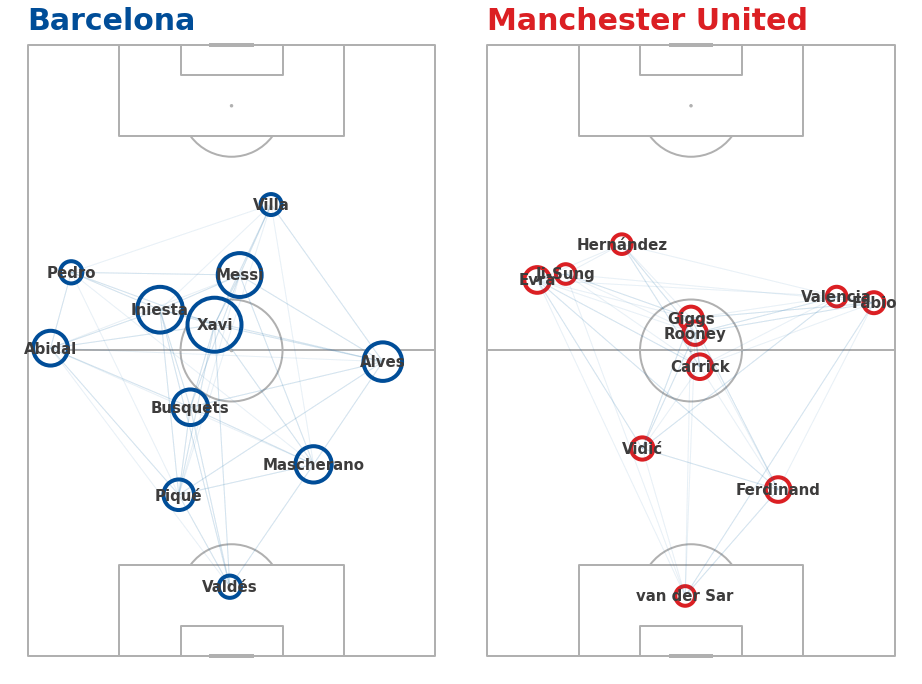

In [19]:
create_plot_passing_network([0, 28], ['Barcelona', 'Manchester United'], passes_succ, lineup)

Empezamos viendo la fase inicial del juego con unas posiciones bastante marcadas de cada equipo. Por una parte, tenemos al FCB que partió con un 4-3-3 con los laterales (Abidal y Alves) en la línea de medio campo, cierre con dos jugadores (Piqué y Mascherano), extremos asimétricos (Villa tirando hacia dentro y Pedro manteniéndose en la izquierda) y una gran importancia (mayor tamaño de los nodos) del juego interior con Busquets, Xavi, Iniesta y Messi.

Por otro lado, tenemos al MUN que empezó con un 4-4-2. Podemos observar como, seguramente debido a la superioridad del FCB en el medio campo, Rooney bajó mucho a ayudar Giggs y Carrick dejando solo en punta a Hernández. Respecto a las bandas podemos observar un comportamiento similar de ambas, los laterales están a la misma altura que Park-Ji Sung y Valencia.

### Mapa de pases del minuto 28 al minuto 35. Gol del MUN. FCB 1 - 1 MUN.

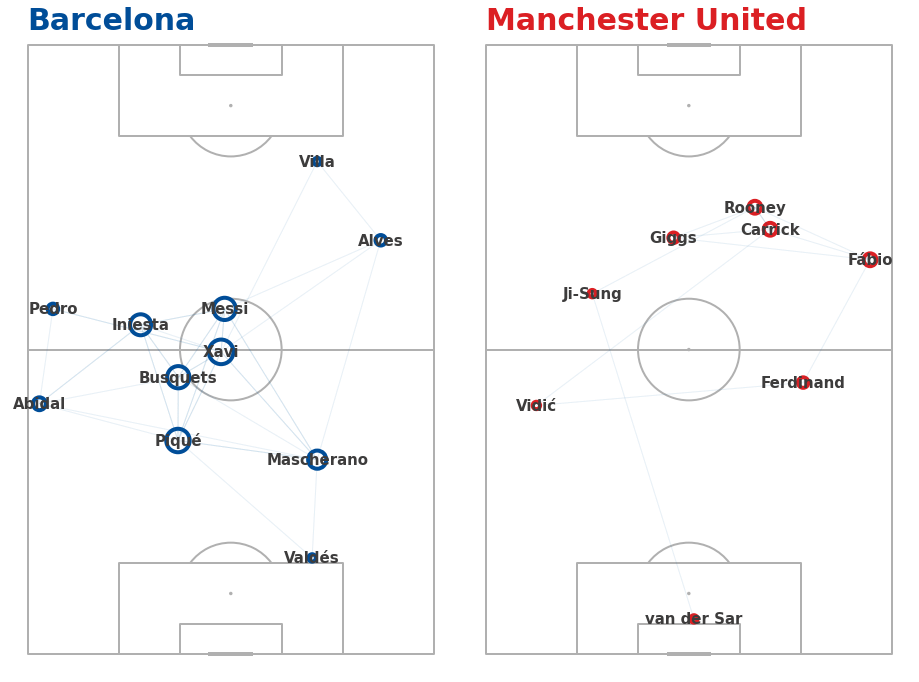

In [114]:
create_plot_passing_network([28, 35], ['Barcelona', 'Manchester United'], passes_succ, lineup)

Después del gol del MUN podemos ver como los jugadores del FCB suben un poco sus posiciones, siendo más destacados Villa y Dani Alves. Por su parte, el MUN sube mucho más sus posiciones, como podemos ver en Giggs, Carrick y Rooney. Podríamos suponer que en esta fase del partido hubo cierto dominio ofensivo del Manchester United que se trasladó en el gol de Wayne Ronney.

### Mapa de pases del minuto 35 al minuto 55. FCB 2 - 1 MUN.

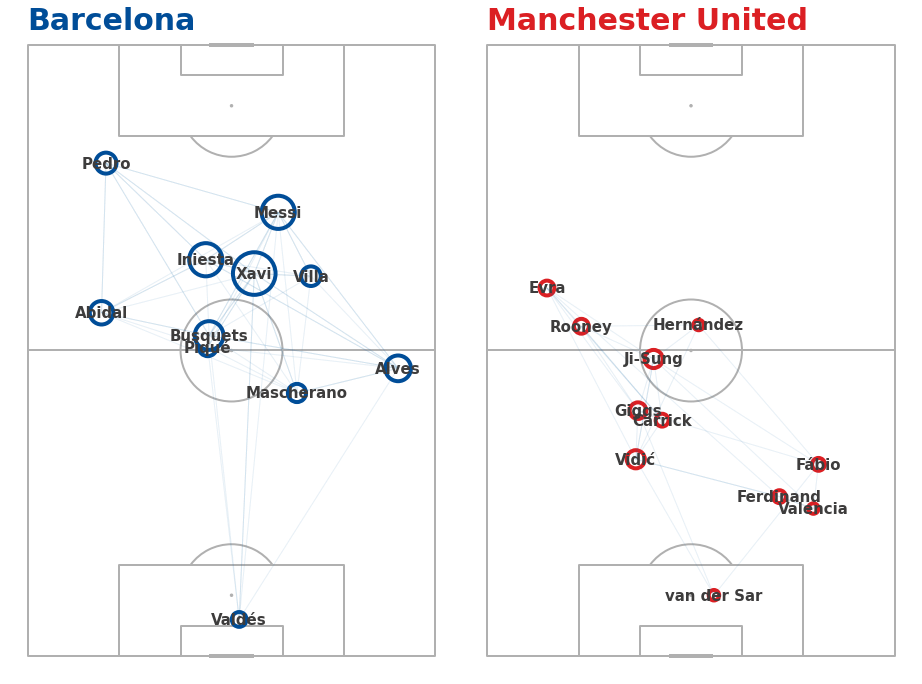

In [115]:
create_plot_passing_network([35, 55], ['Barcelona', 'Manchester United'], passes_succ, lineup)

A partir de este momento se ve claramente un cambio en el comportamiento de los equipos. Gracias al mapa de pases vemos como el FCB empezó a dominar el partido con sus jugadores muy avanzados, dejando solo en su campo a Macherano, Alves y Piqué. En cambio, el MUN tiene a casi todos sus jugadores en campo propio. Este presumiblemente dominio en el juego por parte del FCB hizo que se volvieran a adelantar en el marcador.

### Mapa de pases del minuto 55 al minuto 69. FCB 3 - 1 MUN.

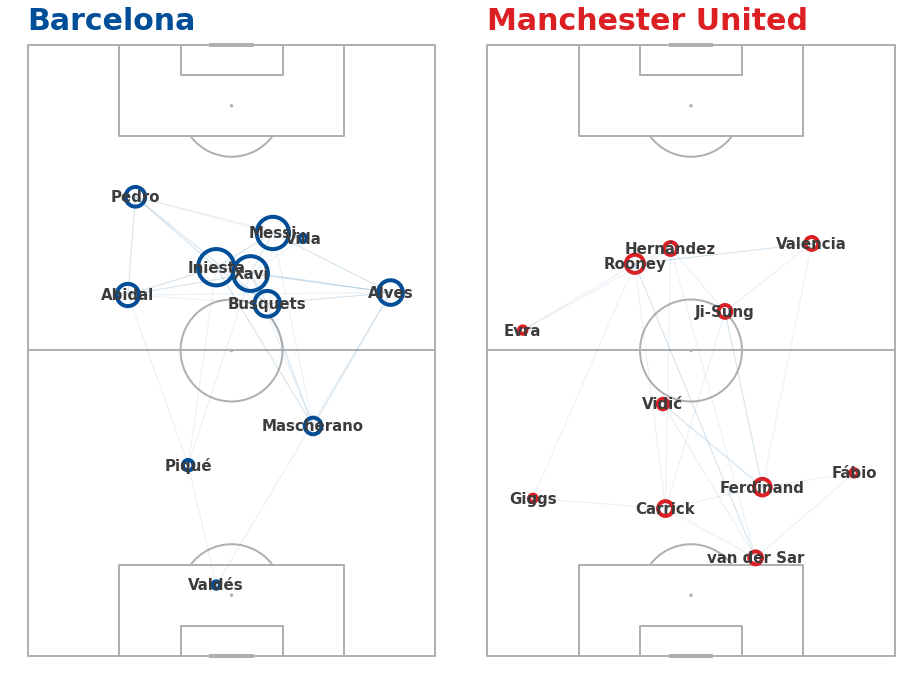

In [116]:
create_plot_passing_network([55, 69], ['Barcelona', 'Manchester United'], passes_succ, lineup)

En esta fase del partido podríamos decir que el FCB sigue dominando al MUN con mucha importancia en el juego interior, destacando Messi, Xavi e Iniesta. El MUN ya no está tan cerrado como en el anterior mapa, aquí vemos como el equipo está más partido entre defensas y delanteros, haciendo el campo muy grande. Esto nos hace indicar que hubo cierta respuesta por parte del MUN, pero que fue infructuosa respecto al dominio del FCB que acabó marcando su tercer gol.

### Mapa de pases del minuto 69 al minuto final del partido. FCB 3 - 1 MUN.

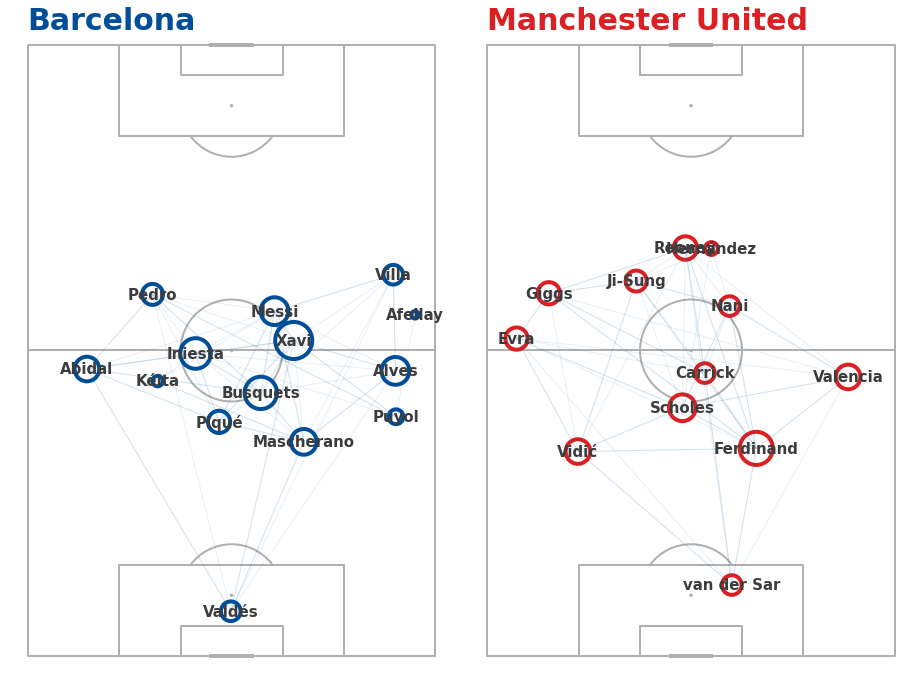

In [117]:
create_plot_passing_network([69, 99], ['Barcelona', 'Manchester United'], passes_succ, lineup)

Con el 3-1 en el marcador llegamos a la fase final del partido. Ambos equipos parecen que reducen el ritmo y ya no son tan ofensivos. Se aprecia claramente como las posiciones medias de los jugadores se mantienen ocupando la centralidad del campo sin ningún jugador mucho más avanzado que el resto. Esto nos puede indicar que ambos equipos asumían ya como inevitable el resultado del partido, el MUN no conseguía ninguna acción que pudiera alterar el marcador y el FCB tenía cierto margen como para dormir el partido sin tener que realizar grandes esfuerzos ofensivos.

# Conclusiones

En este proyecto hemos visto como podemos hacer servir el *big data* para encontrar soluciones en el mundo del fútbol. En concreto hemos realizado lo siguiente:
- Comparación de jugadores.
- Búsqueda de jugadores similares.
- Análisis de un partido mediante mapas de pases.

Pero estos análisis no son los únicos posibles que se pueden realizar. A partir de los datos disponibles se pueden hacer muchos más. Por ejemplo, podríamos analizar más a fondo el partido entre el FCB y MUN viendo el mapa de calor de los equipos, la influencia individual de algún jugador o como han sido los distintos mapas de disparos. Por lo que respecta a los datos de los jugadores, podríamos haber escogido otros atributos u otras maneras de visualización.

En definitiva, la aplicación de técnicas de análisis de datos en el mundo del fútbol nos ofrece una infinidad de posibilidades para mejorar en distintas áreas como la búsqueda de jugadores, el análisis de partidos, el desempeño de los jugadores en el campo, etc.